### Module 7: Stream Algorithms

We wish to estimate the surprise number (2nd moment) of a data stream, using the method of AMS. It happens that our stream consists of ten different values, which we'll call 1, 2,..., 10, that cycle repeatedly. That is, at timestamps 1 through 10, the element of the stream equals the timestamp, at timestamps 11 through 20, the element is the timestamp minus 10, and so on. It is now timestamp 75, and a 5 has just been read from the stream. As a start, you should calculate the surprise number for this time.

For our estimate of the surprise number, we shall choose three timestamps at random, and estimate the surprise number from each, using the AMS approach (length of the stream times 2m-1, where m is the number of occurrences of the element of the stream at that timestamp, considering all times from that timestamp on, to the current time). Then, our estimate will be the median of the three resulting values.

You should discover the simple rules that determine the estimate derived from any given timestamp and from any set of three timestamps.

In [19]:
from collections import Counter
from itertools import cycle
import random
from statistics import median

source = cycle(range(1, 11))
stream = [next(source) for n in range(0, 75)]

def surprise_number(stream):
    counter = Counter(stream)
    return sum(count ** 2 for (element, count) in counter.items())
    
def estimate_surprise_number(stream, timestamps):
    estimates = []
    for ts in timestamps:
        element = stream[ts - 1]
        count = stream[ts - 1:].count(element)
        estimate = len(stream) * (2 * count - 1)
        estimates.append(estimate)
    return median(estimates)

variables = [(25, 34, 47),
             (22, 42, 62),
             (30, 47, 62),
             (31, 48, 50)]

print('Surprise Number: {}'.format(surprise_number(stream)))
    
for timestamps in variables:
    print('Est. Surprise Number with variables at {}, {}, {} timestamps: {}'.format(
        *timestamps,
        estimate_surprise_number(stream, timestamps),
    ))


Surprise Number: 565
Est. Surprise Number with variables at 25, 34, 47 timestamps: 675
Est. Surprise Number with variables at 22, 42, 62 timestamps: 525
Est. Surprise Number with variables at 30, 47, 62 timestamps: 375
Est. Surprise Number with variables at 31, 48, 50 timestamps: 375


Suppose we are using the DGIM algorithm of Section 4.6.2 to estimate the number of 1's in suffixes of a sliding window of length 40. The current timestamp is 100, and we have the following buckets stored:

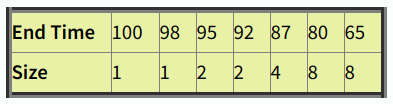

In [21]:
from IPython.display import Image
Image(filename='buckets.png')

Note: we are showing timestamps as absolute values, rather than modulo the window size, as DGIM would do.

Suppose that at times 101 through 105, 1's appear in the stream. Compute the set of buckets that would exist in the system at time 105.

In [50]:
buckets = [(100, 1),
           ( 98, 1),
           ( 95, 2),
           ( 92, 2),
           ( 87, 4),
           ( 80, 8),
           ( 65, 8)]

def merge_buckets(buckets, *args):
    b1, b2 = args
    later_timestamp = max([b1[0], b2[0]])
    total_count = b1[1] + b2[1]
    merged_bucket = (later_timestamp, total_count)
    b1_index = buckets.index(b1)
    b2_index = buckets.index(b2)
    start = min(b1_index, b2_index)
    end = max(b1_index, b2_index)
    return buckets[:start] + [merged_bucket] + buckets[end + 1:]

def get_counter(buckets):
    sizes = [b[1] for b in buckets]
    return Counter(sizes)

def merge_complete(counter):
    return all([count <= 2 for size, count in counter.items()])

def cascade_merge(buckets):
    counter = get_counter(buckets)
    done = merge_complete(counter)
    while not done:
        for size, count in counter.items():
            if count > 2:
                too_many_buckets = [b for b in buckets if b[1] == size]
                # merge the 2 earliest buckets
                buckets_to_merge = sorted(too_many_buckets, key=lambda b: b[1])[-2:]
                buckets = merge_buckets(buckets, *buckets_to_merge)
                counter = get_counter(buckets)
                done = merge_complete(counter)
    return buckets

print('Buckets at time 100: {}'.format(buckets))

for idx, el in enumerate('11111'):
    buckets.insert(0, (100 + idx + 1, int(el)))
    buckets = cascade_merge(buckets)
    print('Buckets at time {}: {}'.format(100 + idx + 1, buckets))    

Buckets at time 100: [(100, 1), (98, 1), (95, 2), (92, 2), (87, 4), (80, 8), (65, 8)]
Buckets at time 101: [(101, 1), (100, 2), (95, 4), (87, 4), (80, 8), (65, 8)]
Buckets at time 102: [(102, 1), (101, 1), (100, 2), (95, 4), (87, 4), (80, 8), (65, 8)]
Buckets at time 103: [(103, 1), (102, 2), (100, 2), (95, 4), (87, 4), (80, 8), (65, 8)]
Buckets at time 104: [(104, 1), (103, 1), (102, 2), (100, 2), (95, 4), (87, 4), (80, 8), (65, 8)]
Buckets at time 105: [(105, 1), (104, 2), (102, 4), (95, 8), (80, 16)]


We wish to use the Flagolet-Martin algorithm of Section 4.4 to count the number of distinct elements in a stream. Suppose that there are ten possible elements, 1, 2,..., 10, that could appear in the stream, but only four of them have actually appeared. To make our estimate of the count of distinct elements, we hash each element to a 4-bit binary number. The element x is hashed to 3x + 7 (modulo 11). For example, element 8 hashes to 3*8+7 = 31, which is 9 modulo 11 (i.e., the remainder of 31/11 is 9). Thus, the 4-bit string for element 8 is 1001.

A set of four of the elements 1 through 10 could give an estimate that is exact (if the estimate is 4), or too high, or too low. You should figure out under what circumstances a set of four elements falls into each of those categories.

In [61]:
possible_elements = range(1, 11)

element_sets = [(4, 5, 6, 10),
                (1, 5, 8,  9),
                (2, 6, 8, 10),
                (2, 6, 8,  9)]

def hash_function(x):
    number = (3 * x + 7) % 11
    return format(number, '04b')
    
for elements in element_sets:
    hashes = []
    for el in elements:
        hashes.append(hash_function(el))
    max_trailing_zeroes = max([len(h) - len(h.rstrip('0')) for h in hashes])
    print('Estimate for elements {}: {}'.format(elements, 2 ** max_trailing_zeroes))

Estimate for elements (4, 5, 6, 10): 16
Estimate for elements (1, 5, 8, 9): 16
Estimate for elements (2, 6, 8, 10): 4
Estimate for elements (2, 6, 8, 9): 2


A certain Web mail service (like gmail, e.g.) has 10^8 users, and wishes to create a sample of data about these users, occupying 10^10 bytes. Activity at the service can be viewed as a stream of elements, each of which is an email. The element contains the ID of the sender, which must be one of the 10^8 users of the service, and other information, e.g., the recipient(s), and contents of the message. The plan is to pick a subset of the users and collect in the 10^10 bytes records of length 100 bytes about every email sent by the users in the selected set (and nothing about other users).

The method of Section 4.2.4 will be used. User ID's will be hashed to a bucket number, from 0 to 999,999. At all times, there will be a threshold t such that the 100-byte records for all the users whose ID's hash to t or less will be retained, and other users' records will not be retained. You may assume that each user generates emails at exactly the same rate as other users. As a function of n, the number of emails in the stream so far, what should the threshold t be in order that the selected records will not exceed the 10^10 bytes available to store records? From the list below, identify the true statement about a value of n and its value of t.

In [67]:
storage_space = 10 ** 10
email_size = 100

variable_sets = [(10 ** 12, 999),
                 (10 **  9, 999),
                 (10 ** 11, 999),
                 (10 ** 14,   1)]

for num_emails, threshold in variable_sets:
    total_size = num_emails * email_size
    fraction = storage_space / total_size
    appropriate_threshold = fraction * 10**6 - 1
    print('Emails: {}, threshold: {}, appropriate threshold: {}'.format(
        '{:.0e}'.format(num_emails),
        threshold,
        appropriate_threshold,
    ))

Emails: 1e+12, threshold: 999, appropriate threshold: 99.0
Emails: 1e+09, threshold: 999, appropriate threshold: 99999.0
Emails: 1e+11, threshold: 999, appropriate threshold: 999.0
Emails: 1e+14, threshold: 1, appropriate threshold: 0.0


Suppose we hash the elements of a set S having 23 members, to a bit array of length 100. The array is initially all-0's, and we set a bit to 1 whenever a member of S hashes to it. The hash function is random and uniform in its distribution. What is the expected fraction of 0's in the array after hashing? What is the expected fraction of 1's? You may assume that 100 is large enough that asymptotic limits are reached.

In [73]:
import numpy as np

num_elements = 23
bit_array_length = 100

fraction_0s = np.exp(-23/100)
fraction_1s = 1 - fraction_0s

print('Expected fraction of 0s: {:.2}'.format(fraction_0s))
print('Expected fraction of 1s: {:.2}'.format(fraction_1s))

Expected fraction of 0s: 0.79
Expected fraction of 1s: 0.21
